In [224]:
%matplotlib inline
import os
import sys
cwd = os.getcwd()
sys.path.append(os.path.join(cwd, '..'))

import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from aye.visualization import *
from aye.preprocessing import *
from aye.blob_analysis import *
from aye.bounding_box import *
from aye.optical_flow import calc_bboxes_flow
from aye.fruit_detector import FruitDetector
from aye.fruit_tracker import FruitTracker
from sklearn.externals import joblib

# Labeled data

Labeled in GIMP on raw images

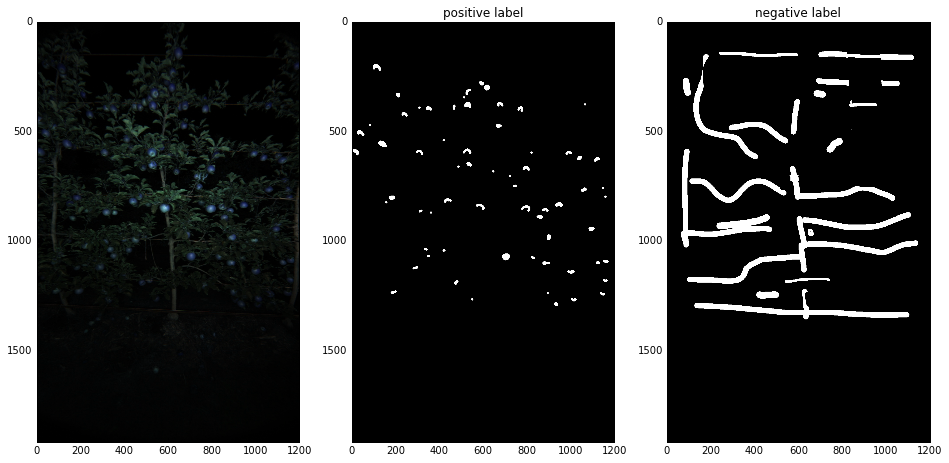

In [225]:
reader = DataReader()
image, labels = reader.read_image_with_label(0)

image = rotate_image(image)
labels[0] = rotate_image(labels[0])
labels[1] = rotate_image(labels[1])

fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(131)
ax.imshow(image)
ax = fig.add_subplot(132)
ax.set_title('color image')
ax.imshow(labels[0], cmap=plt.cm.gray)
ax.set_title('positive label')
ax = fig.add_subplot(133)
ax.imshow(labels[1], cmap=plt.cm.gray)
ax.set_title('negative label')

# Image in different colorspaces

Look at image in RGB, HSV and LAB

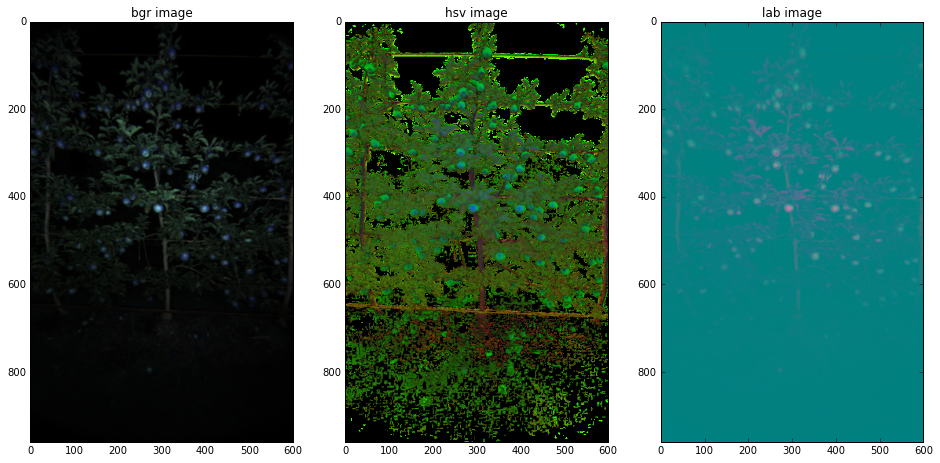

In [226]:
s = Samples(image, labels=labels, k=0.5)

fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(131)
ax.imshow(s.im_bgr)
ax.set_title('bgr image')
ax = fig.add_subplot(132)
ax.imshow(s.im_hsv)
ax.set_title('hsv image')
ax = fig.add_subplot(133)
ax.imshow(s.im_lab)
ax.set_title('lab image')

# Distribution of labels in colorspaces

Clearly there's some hyperplane that can seperate the data in this high dimensional space

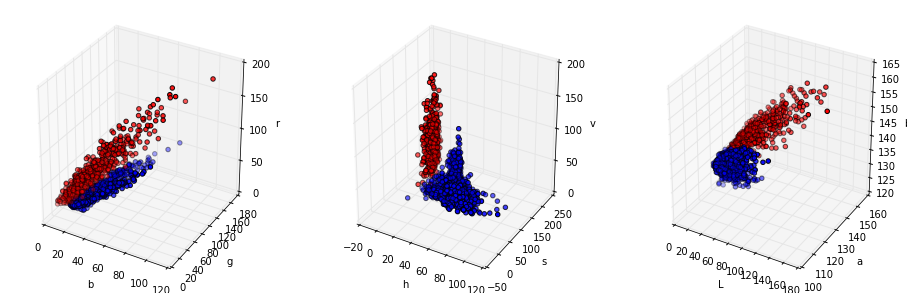

In [227]:
X_pos, y_pos = s.Xy_pos()
X_neg, y_neg = s.Xy_neg()

r = 10
fig = plt.figure(figsize=(16, 5))

ax = fig.add_subplot(131, projection='3d')
ax.scatter(X_pos[::r, 0], X_pos[::r, 1], X_pos[::r, 2], c='r')
ax.scatter(X_neg[::r, 0], X_neg[::r, 1], X_neg[::r, 2], c='b')
ax.set_xlabel('b')
ax.set_ylabel('g')
ax.set_zlabel('r')

ax = fig.add_subplot(132, projection='3d')
ax.scatter(X_pos[::r, 3], X_pos[::r, 4], X_pos[::r, 5], c='r')
ax.scatter(X_neg[::r, 3], X_neg[::r, 4], X_neg[::r, 5], c='b')
ax.set_xlabel('h')
ax.set_ylabel('s')
ax.set_zlabel('v')

ax = fig.add_subplot(133, projection='3d')
ax.scatter(X_pos[::r, 6], X_pos[::r, 7], X_pos[::r, 8], c='r')
ax.scatter(X_neg[::r, 6], X_neg[::r, 7], X_neg[::r, 8], c='b')
ax.set_xlabel('L')
ax.set_ylabel('a')
ax.set_zlabel('b')

# Crop useless part of the image

Reduce number of pixel from 1920 * 1200 to 1480 * 800 which is factor of 2

2.0


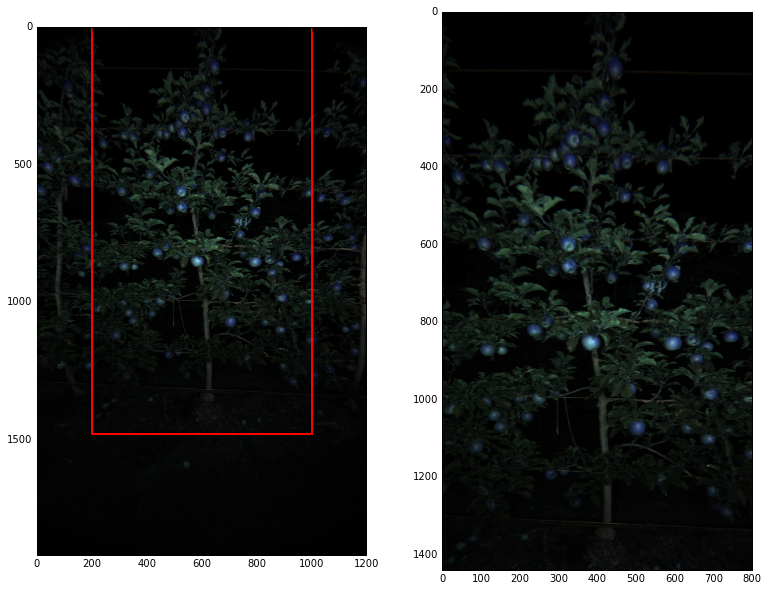

In [228]:
disp = np.array(image, copy=True)
cv2.rectangle(disp, (200, 0), (1000, 1480), color=(255, 0, 0), thickness=5)
image_crop = image[:1440, 200:1000]

fig = plt.figure(figsize=(13, 10))
ax = fig.add_subplot(121)
ax.imshow(disp)
ax = fig.add_subplot(122)
ax.imshow(image_crop)
print(1920.0 * 1200 / 1440 / 800)

# Trained an SVM to classify pixels into fruit and nonfruit

Using a 9-dimensional feature vector  
The above 1440 * 800 image is subsample again to 720 * 400 or even 360 * 200  
Could possibly do better by including image position as features, but colors suffice for now

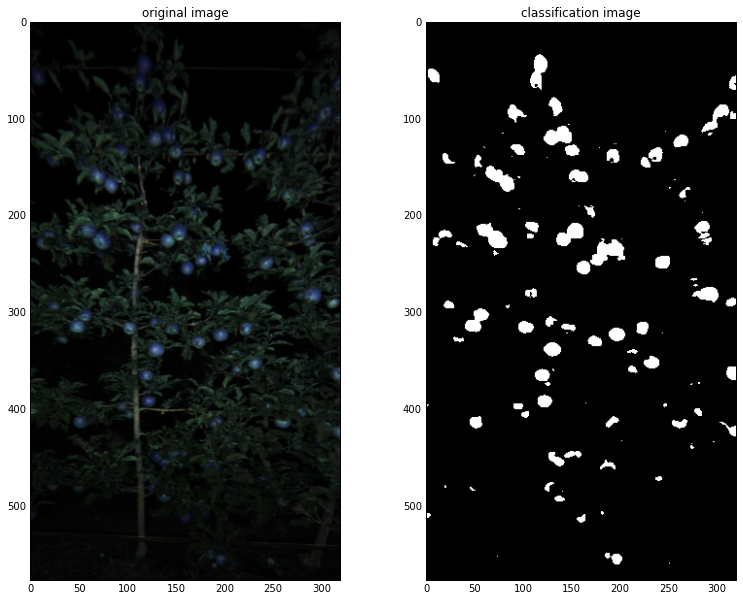

In [229]:
clf = joblib.load('../model/svc.pkl')
scaler = joblib.load('../model/scaler.pkl')
detector = FruitDetector(clf, scaler)

# Load another image for testing
reader = DataReader(rel_dir="./images", ext="jpg")
image = reader.read_image(1)
image = rotate_image(image)
image = image[:1440, 200:1000]

k = 0.4
s, bw = detector.detect(image, k=k)

fig = plt.figure(figsize=(13, 10))
ax = fig.add_subplot(121)
ax.imshow(s.im_raw)
ax.set_title("original image")
ax = fig.add_subplot(122)
ax.imshow(bw, cmap=plt.cm.gray)
ax.set_title("classification image")

# Mask cleanup and blob analysis

Use morph opening to cleanup the mask  
Then do contour analysis to find connected components  
Then only blobs that have a decent area is selected

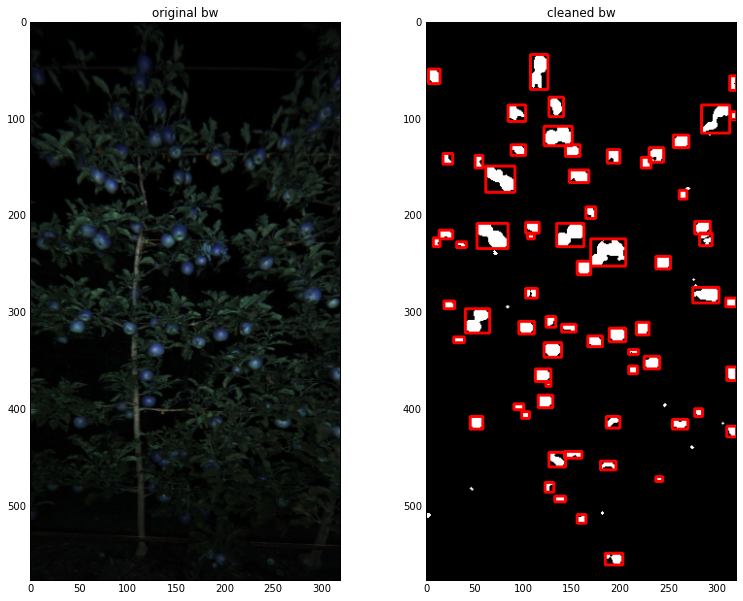

In [230]:
blobs, bw_filled = region_props(bw, min_area=10)
disp_bw = cv2.cvtColor(bw_filled, cv2.COLOR_GRAY2BGR)
draw_bboxes(disp_bw, blobs['bbox'], color=(255, 0, 0), thickness=2)

fig = plt.figure(figsize=(13, 10))
ax = fig.add_subplot(121)
ax.imshow(s.im_raw)
ax.set_title("original bw")
ax = fig.add_subplot(122)
ax.imshow(disp_bw, cmap=plt.cm.gray)
ax.set_title("cleaned bw")

# Handle multiple fruits by detecting local maxima

Can also be improved, sometimes give more than detected

2


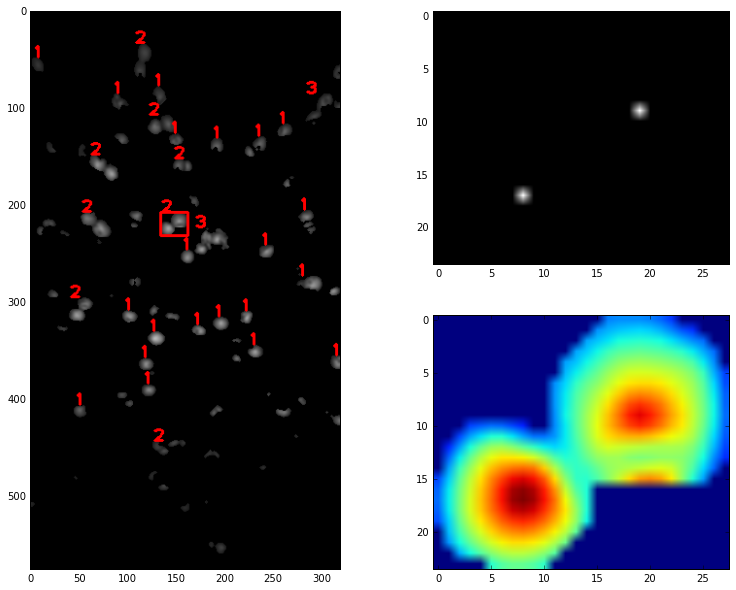

In [231]:
def num_local_maximas_disp(image, n=12):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (n, n))
    peak = cv2.dilate(image, kernel, iterations=1)
    peak -= image

    flat = cv2.erode(image, kernel, iterations=1)
    flat = image - flat

    peak[peak > 0] = 255
    flat[flat > 0] = 255

    flat = cv2.bitwise_not(flat)
    peak[flat > 0] = 255
    peak = cv2.bitwise_not(peak)

    cs, _ = cv2.findContours(peak, mode=cv2.RETR_EXTERNAL,
                             method=cv2.CHAIN_APPROX_SIMPLE)
    return len(cs), peak

blobs_big = thresh_blobs_area(blobs, area=100)

v = s.im_hsv[:,:,-1]
v_bw = np.array(v, copy=True)
v_bw[~(bw_filled > 0)] = 0
v_disp = cv2.cvtColor(v_bw, cv2.COLOR_GRAY2BGR)


for blob in blobs_big:
    bbox = blob['bbox']
    x, y, w, h = bbox
    region = extract_bbox(v_bw, bbox)
    n, _ = num_local_maximas_disp(region)
    cv2.putText(v_disp, str(n), (x, y), cv2.FONT_HERSHEY_PLAIN, 1.2, color=(255, 0, 0), thickness=2)

    
blob = blobs_big[16]
v_blob = extract_bbox(v_bw, blob['bbox'])
n, v_peak = num_local_maximas_disp(v_blob)
draw_bboxes(v_disp, blob['bbox'], color=(255, 0, 0), thickness=2)
print(n)

fig = plt.figure(figsize=(13, 10))
ax = plt.subplot2grid((2, 2), (0, 0), rowspan=2)
ax.imshow(v_disp)
ax = plt.subplot2grid((2, 2), (0, 1))
ax.imshow(v_peak, cmap=plt.cm.gray)
ax = plt.subplot2grid((2, 2), (1, 1))
ax.imshow(v_blob)

# For every new detection, initialize a Kalman filter

Use klt at every detection as the kalman filter prediction step

In [239]:
tracker = FruitTracker()
tracker.track(s, blobs, bw)

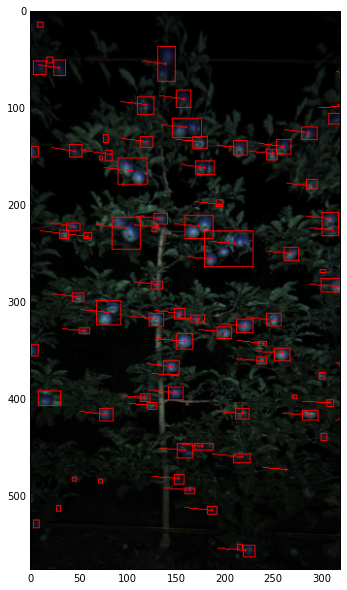

In [240]:
blobs_prev = blobs
gray_prev = cv2.cvtColor(s.im_raw, cv2.COLOR_BGR2GRAY)

image = reader.read_image(2)
image = rotate_image(image)
image = image[:1440, 200:1000]

s2, bw2 = detector.detect(image, k=k)
blobs2, bw2 = region_props(bw2)
gray = cv2.cvtColor(s2.im_raw, cv2.COLOR_BGR2GRAY)

disp = np.array(s2.im_raw, copy=True)

p1s, p2s, sts = calc_bboxes_flow(gray_prev, gray, blobs_prev['bbox'])
draw_optical_flow(disp, p1s, p2s, color=Colors.optical_flow)
draw_bboxes(disp, blobs2['bbox'], color=Colors.detection)

fig = plt.figure(figsize=(10, 10))
plt.imshow(disp)

# Use a variant of hungarian algorithm to assign detections to tracks

See examples from bbox.ipynb  
Unassigned bounding boxes will spawn new tracks  
Unassigned tracks will be deleted, and the number of fruit will be counted if the track lasts long enough  
Assigned tracks will use assigned detections as Kalman filter correction step  
Kalman filter state is just position in image

Red is optical flow  
Blue is predicted bounding boxes   
Yellow is a valid track  
White is new detection  

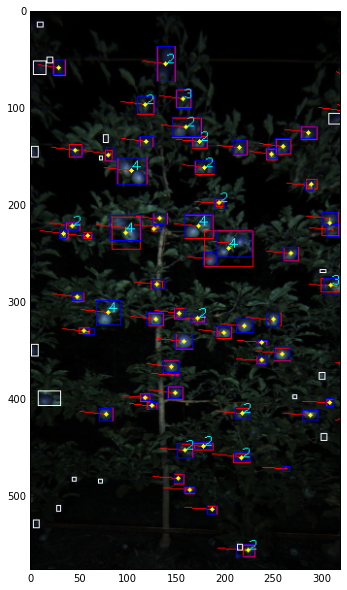

In [241]:
tracker.track(s2, blobs2, bw2)
fig = plt.figure(figsize=(12, 10))
plt.imshow(tracker.disp)

# Just keep doing this until we run out of images

# What I learned

* Can do decent detection with very low resolution
* For better tracking need a bit higher frame rate
* A lot of the pixels are cropped out anyway
* Thus would be nice to use the chameleon3 camera, with leds and running at higher rate
* Could also remove bluefox2, and just use a color chameleon3 for both counting and estimation
* Python is awesome
    * Rewrite everything in 5 days
    * The matlab one took us 1 month

# What to do next

* Tune this thing for a bit and send a report to KyleT
* Depends on whether we plan to go back next year, update the platform
    * Just use chameleon3 + pixhawk (imu + mag + gps) or maybe a better imu since we have it
    * Then this setup is compact and can be put on any robot or drones if desired
* Since we have the tracks, we could try bundle adjusting it
* The problem is the association is bad
    * Multiple detections is not handled very well
    * Fruit merging and splitting is not handled at all
    * This will cause problem in optimization
    * Probably need a robustifier, but then those connections will be deleted from the graph
    * ...